# Beam creation example

This notebook creates Fig 4. from the paper "Focused beam propagation in cholesteric liquid crystals"
The method is explained in the paper.



In [47]:
# The imports
import dtmm2.tmm as tmm

from dtmm2.conf import FDTYPE, CDTYPE

from dtmm2 import wave
from dtmm2.linalg import dotmv
from dtmm2.field import field2modes, modes2field
from dtmm2.source import scalar_field, vector_field


import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

Number of modes: 1793


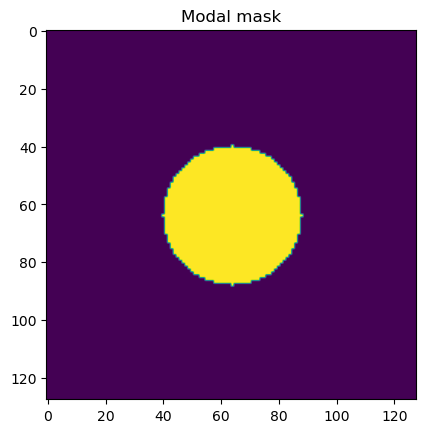

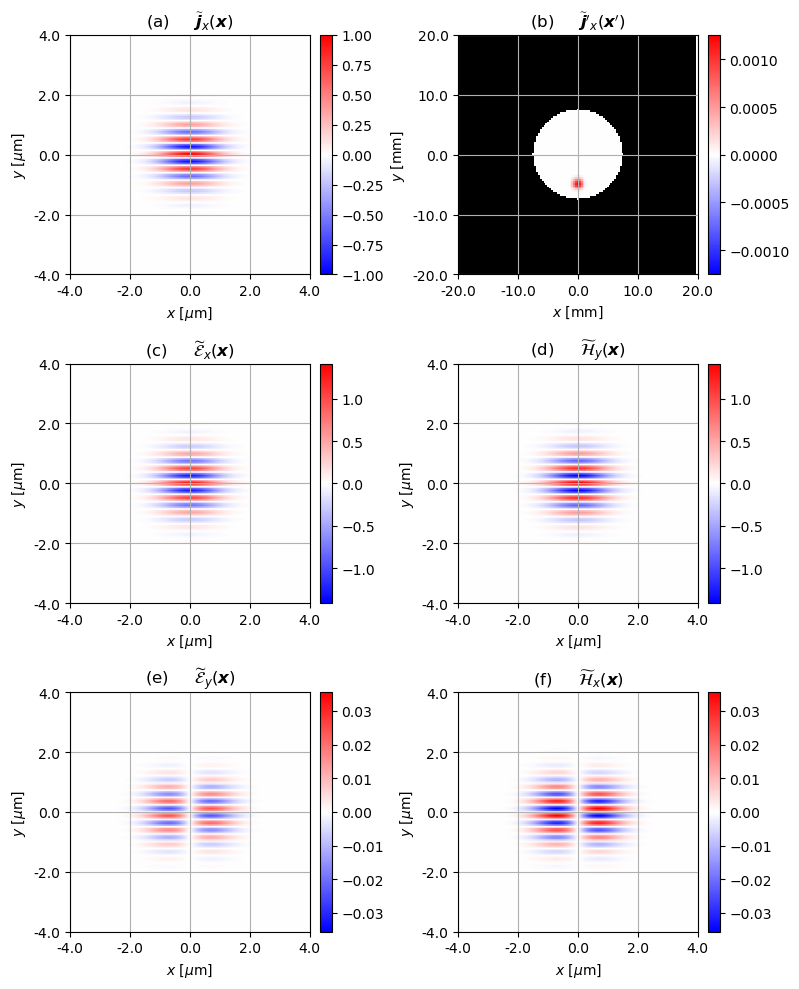

In [48]:
#: We use a square pixel and square domain. How many pixels
N = 128

#: shape
SHAPE = (N,N)

#: domain size in um
SIZE = 8 

#: pixel size in nm
PIXELSIZE = SIZE*1000/N 

#: wavelength in nm
WAVELENGTH = 500

#: waist size in um
WAIST = 1 

#: objective lens focal length in mm
FOCAL = 5 

#: Fourier plane pixel size in mm
FOURIER_PIXELSIZE = FOCAL*WAVELENGTH/PIXELSIZE/N 

#: Fourier plane size in mm
FOURIER_SIZE = FOURIER_PIXELSIZE * N 

KI = 16
KJ = 0

K0 = wave.k0(WAVELENGTH,PIXELSIZE)
mask = wave.eigenmask(SHAPE,K0, betamax = 1.5)
print("Number of modes:",mask.sum())

plt.imshow(np.fft.fftshift(mask))
plt.title("Modal mask")

FIGSIZE = (8,10)

def set_ticks(ax, size = SIZE, units = "$\mu$m"):
    NTICKS = 5
    
    xt = np.linspace(-0.5, 2*(N//2)+0.5, NTICKS)
    xl = np.linspace(-size/2,size/2,NTICKS)
    xl = [f"{x:.1f}" for x in xl]
    
    ax.set_xticks(xt)
    ax.set_yticks(xt)
    ax.set_xticklabels(xl)
    ax.set_yticklabels(xl)
    ax.set_xlabel("$x$ " + f"[{units}]")
    ax.set_ylabel("$y$ " + f"[{units}]")
    ax.grid()

def add_colorbar(fig,im,ax, pad = 0.1, pack_start = False):
    # add color bar below chart
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size = '5%', pad = pad ,pack_start = pack_start)
    fig.add_axes(cax)
    
    fig.colorbar(im, cax = cax, orientation = 'vertical')
    
def gaussian_window(x,y, waist = WAIST, center = (0.,0.)):
    return np.asarray(np.exp(-((x-center[0])**2+(y-center[1])**2)/waist**2),CDTYPE)

yw = np.fft.fftfreq(N,d = 1/N)*PIXELSIZE/1000
xw = np.fft.fftfreq(N,d = 1/N)*PIXELSIZE/1000

#we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
yy,xx = np.meshgrid(yw,xw, indexing = 'ij')

amplitude = gaussian_window(xx,yy)
phase = wave.eigenwave(SHAPE,KI,KJ)
beam = amplitude * phase

fbeam = 1j*np.fft.ifft2(beam, norm = "ortho")
fbeam[np.logical_not(mask)] = 0

beam = -1j*np.fft.fft2(fbeam, norm = "ortho")

#: set this to None, we use this in imshow to display black color
fbeam[np.logical_not(mask)] = np.nan

#: the amplitude in fourier plane 
fbeam *= SIZE/(FOURIER_SIZE*1000)

# the Jones representation
jones = np.zeros(shape = (4,) + beam.shape, dtype = beam.dtype)
jones[0] = beam

fig,axs = plt.subplots(3,2, figsize = FIGSIZE)

vmax = fbeam[mask].imag.max()
vmin = -vmax

cmap = mpl.colormaps.get_cmap('bwr')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ax = axs[0,1]
im = ax.imshow(np.fft.fftshift(fbeam).imag, cmap = cmap, origin = "lower", vmin = vmin, vmax = vmax, interpolation = "nearest")
add_colorbar(fig,im,ax)
ax.set_title("(b)\t"+r"$\widetilde{\boldsymbol{j}}'_x(\boldsymbol{x}')$")
set_ticks(ax, size = FOURIER_SIZE, units = "mm")

vmax = 1
vmin = -vmax

ax = axs[0,0]
im = ax.imshow(np.fft.fftshift(jones[0].real), origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
add_colorbar(fig,im,ax)
ax.set_title("(a)\t"+r"$\widetilde{\boldsymbol{j}}_x(\boldsymbol{x})$")
set_ticks(ax)

bmat = tmm.modal_beam_mat(K0, epsilon = 1.5**2, mask = mask)
mask, modes = field2modes(jones, k0 = K0, mask = mask)
modes = dotmv(bmat, modes)

field = modes2field(mask,modes)

vmax = vmax*np.sqrt(2)
vmin = -vmax

ax = axs[1,0]
im = ax.imshow(np.fft.fftshift(field[0].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
add_colorbar(fig,im,ax)
ax.set_title("(c)\t"+r"$\widetilde{\mathcal{E}}_x(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[1,1]
im = ax.imshow(np.fft.fftshift(field[1].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(d)\t"+r"$\widetilde{\mathcal{H}}_y(\boldsymbol{x})$")
set_ticks(ax)

vmax = max(field[2].real.max(),field[3].real.max())
vmin = -vmax

ax = axs[2,0]
im = ax.imshow(np.fft.fftshift(field[2].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$\widetilde{\mathcal{E}}_y(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[2,1]
im = ax.imshow(np.fft.fftshift(field[3].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$\widetilde{\mathcal{H}}_x(\boldsymbol{x})$")
set_ticks(ax)

plt.tight_layout()
plt.savefig("beam_creation.pdf")

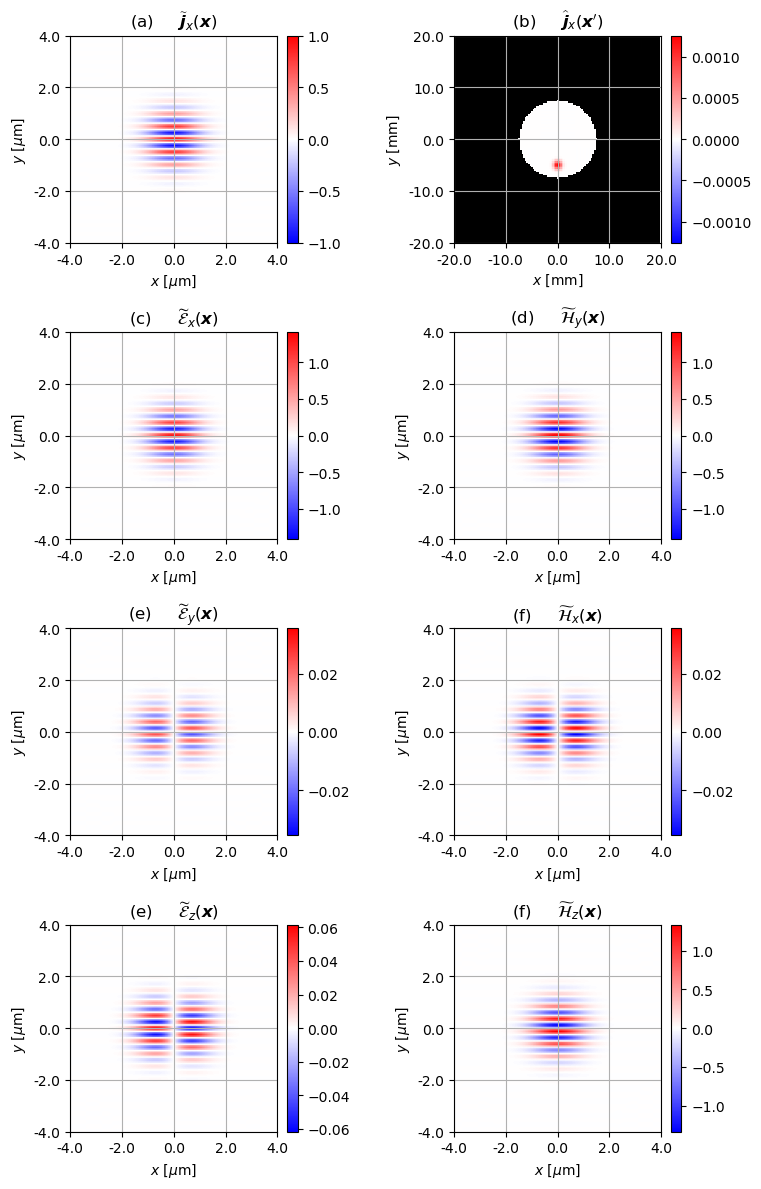

In [38]:
KI = 16
WAIST = 1

FIGSIZE = (8,12)

beam = gaussian_window(xx,yy, waist = WAIST)
phase = wave.eigenwave(SHAPE,KI,KJ)

beam = beam * phase

fbeam = 1j*np.fft.ifft2(beam, norm = "ortho")
fbeam[np.logical_not(mask)] = 0

beam = -1j*np.fft.fft2(fbeam, norm = "ortho")

fbeam[np.logical_not(mask)] = np.nan
fbeam *= SIZE/(FOURIER_SIZE*1000)

jones = np.zeros(shape = (4,) + beam.shape, dtype = beam.dtype)
jones[0] = beam

fig,axs = plt.subplots(4,2, figsize = FIGSIZE)

vmax = fbeam[mask].imag.max()
vmin = -vmax

cmap = mpl.colormaps.get_cmap('bwr')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ax = axs[0,1]
im = ax.imshow(np.fft.fftshift(fbeam).imag, cmap = cmap, origin = "lower", vmin = vmin, vmax = vmax, interpolation = "nearest")
add_colorbar(fig,im,ax)
ax.set_title("(b)\t"+r"$\widehat{\boldsymbol{j}}_x(\boldsymbol{x}')$")
set_ticks(ax, size = FOURIER_SIZE, units = "mm")

vmax = 1
vmin = -vmax

ax = axs[0,0]
im = ax.imshow(np.fft.fftshift(jones[0].real), origin = "lower", cmap = cmap, vmin = vmin, vmax = vmax)
add_colorbar(fig,im,ax)
ax.set_title("(a)\t"+r"$\widetilde{\boldsymbol{j}}_x(\boldsymbol{x})$")
set_ticks(ax)

bmat = tmm.modal_beam_mat(K0, epsilon = 1.5**2, mask = mask, field = "f")
mask, modes = field2modes(jones, k0 = K0, mask = mask)
modes = dotmv(bmat, modes)

field = modes2field(mask,modes)


vmax = vmax*np.sqrt(2)
vmin = -vmax

ax = axs[1,0]
im = ax.imshow(np.fft.fftshift(field[1].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
add_colorbar(fig,im,ax)
ax.set_title("(c)\t"+r"$\widetilde{\mathcal{E}}_x(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[1,1]
im = ax.imshow(np.fft.fftshift(field[2].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(d)\t"+r"$\widetilde{\mathcal{H}}_y(\boldsymbol{x})$")
set_ticks(ax)

vmax = max(field[3].real.max(),field[4].real.max())
vmin = -vmax

ax = axs[2,0]
im = ax.imshow(np.fft.fftshift(field[3].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$\widetilde{\mathcal{E}}_y(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[2,1]
im = ax.imshow(np.fft.fftshift(field[4].real), origin = "lower", vmin = vmin, vmax = vmax, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$\widetilde{\mathcal{H}}_x(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[3,0]
im = ax.imshow(np.fft.fftshift(field[5].imag), origin = "lower",  cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(e)\t"+r"$\widetilde{\mathcal{E}}_z(\boldsymbol{x})$")
set_ticks(ax)

ax = axs[3,1]
im = ax.imshow(np.fft.fftshift(field[0].imag), origin = "lower", cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])
add_colorbar(fig,im,ax)
ax.set_title("(f)\t"+r"$\widetilde{\mathcal{H}}_z(\boldsymbol{x})$")
set_ticks(ax)


plt.tight_layout()

plt.savefig("beam_creation.pdf")

